In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

## Digits Dataset

In [ ]:
X, y = load_digits(n_class=10, return_X_y=True)
X.shape

(1797, 64)

In [ ]:
assert X.shape[:1] == y.shape

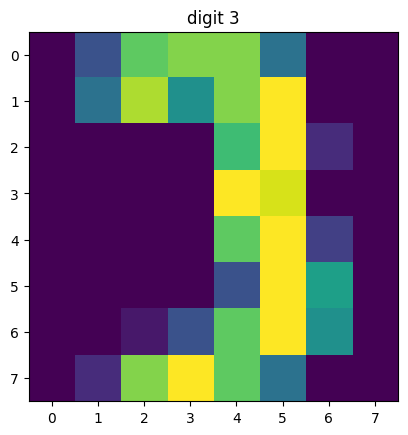

In [ ]:
ix = np.random.randint(0, y.size)

plt.imshow(X[ix].reshape(8, 8))
plt.title(f'digit {y[ix]}')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

## Random Features

We need many `stupid` classifiers which make `errors in different parts` of the feature space.

In [ ]:
n_trees = 5

Make an array to store probability predictions for different runs.

In [ ]:
y_probas = np.empty((n_trees, ) + y_test.shape + (10, ))
y_probas.shape

(5, 599, 10)

Train `n_trees` decision tree classifiers and save class probabilities to `y_probas`.

In [ ]:
for i, state in enumerate(range(n_trees)):
    model = DecisionTreeClassifier(max_features=4, max_depth=2, random_state=state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_probas[i] = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    feat_index, = np.nonzero(model.feature_importances_)
    print(f'[{i:02d}] Test accuracy i {accuracy:.3f}')
    print(f'[{i:02d}] Features used for splitting are {feat_index}')

[00] Test accuracy i 0.319
[00] Features used for splitting are [10 33 43]
[01] Test accuracy i 0.352
[01] Features used for splitting are [21 50 54]
[02] Test accuracy i 0.294
[02] Features used for splitting are [ 2 25 44]
[03] Test accuracy i 0.275
[03] Features used for splitting are [10 28 61]
[04] Test accuracy i 0.265
[04] Features used for splitting are [36 43 58]


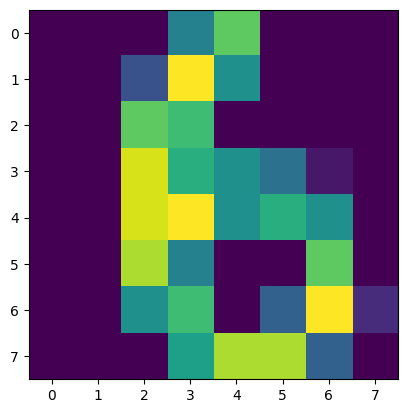

In [ ]:
plt.imshow(X_test[0].reshape(8, 8))

Shape of `y_probas` is `n_trees` x `test_size` x `n_classes`.

In [ ]:
y_probas.shape

(5, 599, 10)

In [ ]:
y_probas[-1, 0].argmax()

6

### Averaging

Let's average prediction of `n_trees` decision trees on a same test set.

In [ ]:
y_proba_mean = y_probas.mean(axis=0)
y_proba_mean.shape

(599, 10)

In [ ]:
y_proba_mean[:3]

array([[0.01275487, 0.13177821, 0.11354822, 0.11483882, 0.10342248,
        0.03542723, 0.26118463, 0.05922296, 0.08820299, 0.07961958],
       [0.10853233, 0.08314822, 0.06579826, 0.20761667, 0.04763271,
        0.13430245, 0.0463106 , 0.04824082, 0.06752656, 0.19089139],
       [0.08518962, 0.0620693 , 0.11322425, 0.25086165, 0.01428571,
        0.10487178, 0.0463393 , 0.02411379, 0.11661885, 0.18242574]])

Make predictions (over the last `n_classes` axis).

In [ ]:
y_pred_mean = np.argmax(y_proba_mean, axis=1)
print(y_pred_mean[:3])

[6 3 3]


Finally, evaluate such model (ensemble of trees) and compreare it with a performance of a single tree.

In [ ]:
score_mean = accuracy_score(y_test, y_pred_mean)
print(f'Score of averaged across ensemble is {score_mean * 100 :.2f}')

Score of averaged across ensemble is 60.93


In [ ]:
score = accuracy_score(y_test, y_probas[0].argmax(axis=1))
print(f'Score of a single tree is {score * 100 :.2f}')

Score of a single tree is 31.89


# 2. Random Observations (Samples)

We can introduce randomization in building a tree with sampling objects from train set (bootstrap).

In [ ]:
def bootstrap_indices(random_state, n_samples):
    """Return random indices with repetition (bootstrap)."""
    return np.random \
        .RandomState(random_state) \
        .randint(low=0, high=n_samples, size=n_samples)

In [ ]:
bootstrap_indices(1, 10)

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9])

In [ ]:
X_train.shape

(1198, 64)

In [ ]:
features = [2, 19, 25, 44]  # fix a set of features.

In [ ]:
y_probas = np.empty((n_trees, ) + y_test.shape + (10, ))
y_probas.shape

(5, 599, 10)

In [ ]:
for i, state in enumerate(range(n_trees)):
    ix = bootstrap_indices(state, X_train.shape[0])
    X_train_ = X_train[ix, :][:, features]
    y_train_ = y_train[ix]
    X_test_ = X_test[:, features]

    model = DecisionTreeClassifier(max_features=4, max_depth=2, random_state=2)
    model.fit(X_train_, y_train_)

    y_pred = model.predict(X_test_)
    y_probas[i] = model.predict_proba(X_test_)

    accuracy = accuracy_score(y_test, y_pred)
    feat_index, = np.nonzero(model.feature_importances_)
    print(f'[{i:02d}] Test accuracy i {accuracy:.3f}')
    print(f'[{i:02d}] Features used for splitting are {feat_index}')

[00] Test accuracy i 0.295
[00] Features used for splitting are [1 2 3]
[01] Test accuracy i 0.269
[01] Features used for splitting are [0 2 3]
[02] Test accuracy i 0.334
[02] Features used for splitting are [0 2 3]
[03] Test accuracy i 0.329
[03] Features used for splitting are [0 2 3]
[04] Test accuracy i 0.290
[04] Features used for splitting are [0 2 3]


Average probablities over `n_trees` axis again and make predictions.

In [ ]:
y_proba_mean = y_probas.mean(axis=0)
y_proba_mean.shape

(599, 10)

In [ ]:
y_pred_mean = np.argmax(y_proba_mean, axis=1)
print(y_pred_mean[:3])

[6 5 3]


In [ ]:
score_mean = accuracy_score(y_test, y_pred_mean)
print(f'Score of averaged across ensemble is {score_mean * 100 :.2f}')

Score of averaged across ensemble is 39.07


### Combined Approach: Features + Objeservations

In [ ]:
models = []
rs = list(range(5))

for state in rs:
    ind = bootstrap_indices(state, X_train.shape[0])
    X_train_, y_train_ = X_train[ind], y_train[ind]

    model = DecisionTreeClassifier(max_features=6, max_depth=2, random_state=state)

    model.fit(X_train_, y_train_)
    models.append(model)  # Save trained model

In [ ]:
predict_proba_models = []
for model in models:
    y_pred_proba = model.predict_proba(X_test)
    predict_proba_models.append(y_pred_proba)
    y_pred = np.argmax(y_pred_proba, axis=1)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
predict_proba_models = np.array(predict_proba_models)

Accuracy: 0.337
Accuracy: 0.356
Accuracy: 0.289
Accuracy: 0.341
Accuracy: 0.275


In [ ]:
mean_predict_proba = predict_proba_models.mean(axis=0)
mean_predict = np.argmax(mean_predict_proba, axis=1)
print('Random Forest Accuracy:', accuracy_score(y_test, mean_predict))

Random Forest Accuracy: 0.5859766277128547


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=5, max_features=6, max_depth=2, random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5659432387312187


We can reuse random states to build a tree manually.

In [ ]:
rs = []
for m in model.estimators_:
    rs.append(m.random_state)
print(rs)

[1791095845, 2135392491, 946286476, 1857819720, 491263]


In [ ]:
def rf_train_test_accuracy(param_name, param_grid, **params):
    """Returns train and test perfomance of a RandomForest for
    different values (param_grid) of a hyperparameter (param_name).
    """

    train_score, test_score = [], []
    clf = RandomForestClassifier(n_estimators=5, max_features=8, max_depth=6, random_state=1, n_jobs=-1)
    if params:
        clf.set_params(**params)

    for param_value in tqdm(param_grid):
        clf.set_params(**{param_name: param_value})
        clf.fit(X_train, y_train)

        train_score.append(accuracy_score(y_train, clf.predict(X_train)))
        test_score.append(accuracy_score(y_test, clf.predict(X_test)))
    return train_score, test_score

## Random Forest: Number of Trees

In [ ]:
train_accuracy, test_accuracy = rf_train_test_accuracy('n_estimators', range(1, 50, 2))

  0%|          | 0/25 [00:00<?, ?it/s]

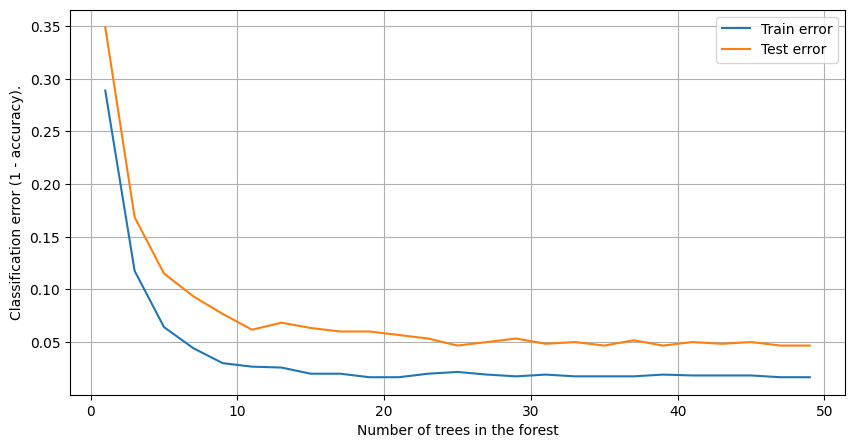

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,50,2)), 1-np.array(train_accuracy), label='Train error')
plt.plot(list(range(1,50,2)), 1-np.array(test_accuracy), label='Test error')
plt.xlabel('Number of trees in the forest')
plt.ylabel('Classification error (1 - accuracy).')
plt.grid(True)
plt.legend()
plt.show()

## Random Forest. Tree Depth

In [ ]:
train_accuracy, test_accuracy = rf_train_test_accuracy('max_depth', range(1, 30))

  0%|          | 0/29 [00:00<?, ?it/s]

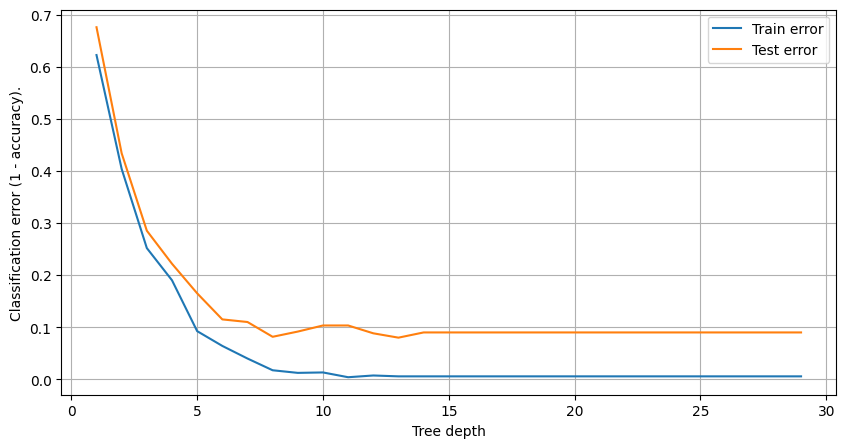

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,30)), 1-np.array(train_accuracy), label='Train error')
plt.plot(list(range(1,30)), 1-np.array(test_accuracy), label='Test error')
plt.xlabel('Tree depth')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest: Number of Max Features

In [ ]:
train_accuracy, test_accuracy = rf_train_test_accuracy('max_features', range(1, 64))

  0%|          | 0/63 [00:00<?, ?it/s]

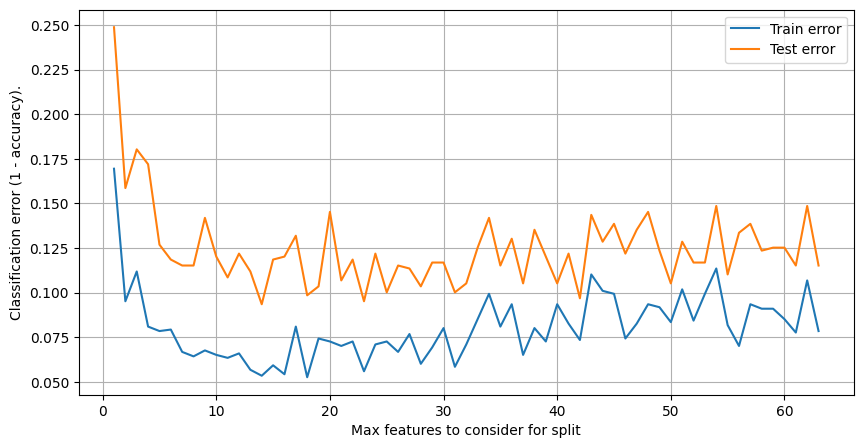

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1, 64)), 1-np.array(train_accuracy), label='Train error')
plt.plot(list(range(1, 64)), 1-np.array(test_accuracy), label='Test error')
plt.xlabel('Max features to consider for split')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
params = {
    'n_estimators': 20,
    'max_depth': 10
}
train_accuracy, test_accuracy = rf_train_test_accuracy('max_features', range(1, 64), **params)

  0%|          | 0/63 [00:00<?, ?it/s]

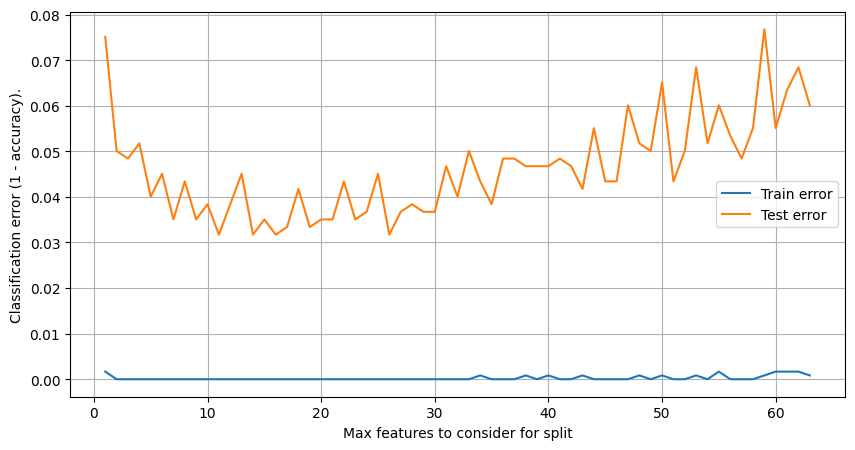

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1, 64)), 1-np.array(train_accuracy), label='Train error')
plt.plot(list(range(1, 64)), 1-np.array(test_accuracy), label='Test error')
plt.xlabel('Max features to consider for split')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend()
plt.grid(True)
plt.show()

Typically something between log2(k) and sqrt(k) will work as a max_features.